# About Dataset:
    

The actual dataset contains headlines for abc news for 15 years. Dataset size is about 1 million records. But, for our purpose, 
we have selected data from 1 Jan 2016 to 30 Jun 2016, which is about 32095 in size.

In [2]:
!pip install nltk


In [1]:
import sagemaker
import boto3
import os
import io
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer


%matplotlib inline

In [3]:
from sagemaker import get_execution_role
role = get_execution_role()
role

'arn:aws:iam::313830654669:role/service-role/AmazonSageMaker-ExecutionRole-20220605T193127'

# Loading Dataset

In [4]:
s3_client = boto3.client('s3')
bucket_name = 'abc-news-2016'
my_region = boto3.session.Session().region_name
print(my_region)

us-east-1


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [11]:
obj_list = s3_client.list_objects(Bucket=bucket_name)
files = []
for contents in obj_list['Contents']:
    files.append(contents['Key'])
print(files)    

['1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', 'results/token.txt', 'token.txt']


# Combining files

In [20]:
files = files[:6]
df = pd.DataFrame()
for file in files:
    response = s3_client.get_object(Bucket=bucket_name, Key=file)
    response_body = response["Body"].read()
    temp = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)
#     print(temp.shape)
    df = df.append(temp, ignore_index = True)
#     print(df.shape)

In [21]:
df.shape

(32095, 2)

In [22]:
df.head()

,publish_date,headline_text
0,2016-01-01,1985 qld cabinet documents mabo decision
1,2016-01-01,49ers juggle jarryd haynes talent mistakes
2,2016-01-01,abjorensen the 2016 battlelines have been drawn
3,2016-01-01,alex ross takes diving catch to dismiss michae...
4,2016-01-01,ama welcome no jab; no pay vaccination policy


In [23]:
print(df.shape)
df = df.drop_duplicates('headline_text')
print(df.shape)

(32095, 2)
(31759, 2)


In [24]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Tokenizing and stemming

In [61]:
words = []
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')
stemmer = SnowballStemmer('english')
def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]
    
df['tokenized'] = df['headline_text'].apply(tokenize)
print(df['tokenized'])
for lst in df['tokenized']:
    words.extend(lst)
print(len(words))

# words = [word for word in words if not word.isnumeric()]
      
from nltk.corpus import stopwords
stops = stopwords.words('english')
words = [word for word in words if word not in stops]
print(len(words))

import string
punctuations = list(string.punctuation)
words = [word for word in words if word not in punctuations]
print(len(words))

print(words[:100])
      

0                    [qld, cabinet, document, mabo, decis]
1                [er, juggl, jarryd, hayn, talent, mistak]
2          [abjorensen, the, battlelin, have, been, drawn]
3        [alex, ross, take, dive, catch, to, dismiss, m...
4          [ama, welcom, no, jab, no, pay, vaccin, polici]
                               ...                        
32090    [west, australian, job, cut, ahead, of, sunday...
32091    [what, is, hoard, examin, the, featur, of, thi...
32092    [wycheproof, p, colleg, student, sing, song, a...
32093    [wyndham, vale, lake, crash, mother, did, noth...
32094    [young, rider, descend, on, toowoomba, for, eq...
Name: tokenized, Length: 31759, dtype: object
243522
200795
200795
['qld', 'cabinet', 'document', 'mabo', 'decis', 'er', 'juggl', 'jarryd', 'hayn', 'talent', 'mistak', 'abjorensen', 'battlelin', 'drawn', 'alex', 'ross', 'take', 'dive', 'catch', 'dismiss', 'michael', 'lumb', 'ama', 'welcom', 'jab', 'pay', 'vaccin', 'polici', 'angri', 'nix', 'coach', 

word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[2000:2100])

In [53]:
with open('token.txt', 'w') as f:
    for token in words:
        f.write(token +"\n")

words = []
with open('token.txt', 'r') as f:
    for line in f:
        words.append(line.strip())
print(len(words))
print(words[:100])

# Uploading the token file to S3

In [54]:
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join('results/','token.txt')).upload_file('token.txt')

# Retrieving the token File 

In [55]:
obj_list = s3_client.list_objects(Bucket=bucket_name)
files = []
for contents in obj_list['Contents']:
    files.append(contents['Key'])
print(files)  

['1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', 'results/token.txt', 'token.txt']


In [56]:
file_name = files[6]
print(file_name)

results/token.txt


In [57]:
response = s3_client.get_object(Bucket=bucket_name, Key=file_name)
response_body = response["Body"].read()
temp = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False)
print(temp.shape, temp.columns[0])

(200794, 1) qld


In [58]:
words = list(temp[temp.columns[0]])
words.insert(0, temp.columns[0])
print(len(words))
print(words[:100])

200795
['qld', 'cabinet', 'document', 'mabo', 'decis', 'er', 'juggl', 'jarryd', 'hayn', 'talent', 'mistak', 'abjorensen', 'battlelin', 'drawn', 'alex', 'ross', 'take', 'dive', 'catch', 'dismiss', 'michael', 'lumb', 'ama', 'welcom', 'jab', 'pay', 'vaccin', 'polici', 'angri', 'nix', 'coach', 'merrick', 'slam', 'odonovan', 'headbutt', 'archbishop', 'philip', 'wilson', 'return', 'work', 'aurora', 'steal', 'show', 'light', 'new', 'year', 'night', 'sky', 'australian', 'flock', 'firework', 'display', 'around', 'countri', 'belgium', 'hold', 'three', 'peopl', 'new', 'year', 'attack', 'plot', 'boat', 'catch', 'fire', 'matilda', 'bay', 'perth', 'bob', 'hawk', 'discuss', 'releas', 'cabinet', 'paper', 'bodi', 'found', 'dure', 'search', 'miss', 'surfer', 'gold', 'coast', 'boulia', 'mayor', 'richard', 'brittain', 'discuss', 'flood', 'assist', 'buckmast', 'hollywood', 'industrialis', 'nostalgia', 'bushfir', 'clear', 'secret', 'harbour', 'south', 'perth', 'cas']



# TFIDF

In [65]:
vectorizer1 = TfidfVectorizer(max_features = 5000)
X1 = vectorizer1.fit_transform(words)
word_features1 = vectorizer1.get_feature_names()
print(len(word_features1))
print(word_features1[:100])

5000
['aaco', 'aaron', 'ab', 'abalon', 'abandon', 'abattoir', 'abba', 'abbott', 'abc', 'abcc', 'abdeslam', 'abduct', 'abl', 'abolish', 'aborigin', 'abort', 'abov', 'absolut', 'abu', 'abus', 'acacia', 'academ', 'academi', 'accc', 'acceler', 'accept', 'access', 'accessori', 'accid', 'accident', 'acclaim', 'accommod', 'accord', 'account', 'accus', 'acdc', 'achiev', 'acid', 'acquir', 'acquisit', 'acquit', 'across', 'act', 'action', 'activ', 'activist', 'actor', 'actual', 'ad', 'adam', 'adani', 'adapt', 'add', 'addict', 'addit', 'address', 'adelaid', 'adf', 'adjourn', 'adjust', 'administr', 'admiss', 'admit', 'adopt', 'adult', 'advanc', 'advantag', 'adventur', 'advertis', 'advic', 'advis', 'advisor', 'advisori', 'advoc', 'aec', 'aerial', 'affair', 'affect', 'afford', 'afghan', 'afghanistan', 'afl', 'afp', 'africa', 'african', 'aft', 'aftermath', 'ag', 'agc', 'age', 'agenc', 'agenda', 'agent', 'agforc', 'aggress', 'agl', 'ago', 'agre', 'agreement', 'agribusi']


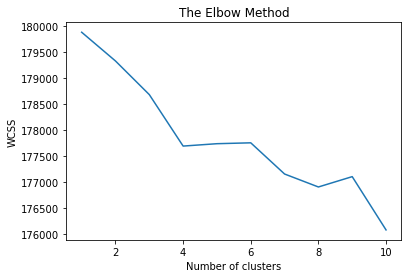

In [66]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=0)
    kmeans.fit(X1)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Kmeans

In [72]:
# n_init(number of iterations for clsutering) n_jobs(number of cpu cores to use)
kmeans = KMeans(n_clusters = 3, n_init = 20, n_jobs = 1) 
kmeans.fit(X1)
# We look at 3 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:,-1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/cluster/_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


0 : bootu, share, record, crowd, car, water, port, lincoln, wharf, chang, action, bus, fare, charli, hebdo, feel, alon, fight, poke, holiday, report, caleb, spot, domin, bay
1 : anim, flood, hope, owner, local, target, man, attack, wait, shoot, fire, landhold, lead, protect, time, tel, mel, three, defenc, strength, oper, mountain, citizen, chris, brisban
2 : ai, share, holiday, car, water, port, lincoln, wharf, chang, action, bus, fare, charli, hebdo, feel, alon, fight, poke, fun, crowd, record, ewan, report, bay, classic


# Prediction

In [75]:
Y = vectorizer1.transform(["landlord attack the man"])
prediction = kmeans.predict(Y)
print(prediction)

[1]
